In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances_argmin_min
# from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from google.colab import files
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [ ]:
# # Mount Google Drive
# drive.mount('/content/drive')

In [ ]:
# For Reduced Features

# Load the data
file_path = '/content/drive/MyDrive/Clinical (Reduced features).csv'
clinical_data = pd.read_csv(file_path)

# Calculating distribution parameters to compare after Imputation
columns_to_average = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB']
actual_average_value = clinical_data[columns_to_average].mean()
actual_median_value = clinical_data[columns_to_average].median()
actual_std_value = clinical_data[columns_to_average].std()

# Dropping Column that do not need Interpolation
columns_dropped_1 = clinical_data.iloc[:, 0:10]  #first 10 Columns
columns_dropped_2 = clinical_data.iloc[:, -5:]   #last 4 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Function for performing Interpolation only on those missing values that have available data above and below it.
def interpolate_missing_values(df, columns):
    for column in columns:
        # Find indices of missing values with both previous and next values available
        indices_missing_with_neighbors = df.index[
            df[column].isnull() & \
            df[column].shift(-1).notnull() & \
            df[column].shift(1).notnull()
        ]

        # Iterate over missing values with both neighbors and perform linear interpolation
        for idx in indices_missing_with_neighbors:
            prev_idx = idx - 1
            next_idx = idx + 1
            prev_value = df.at[prev_idx, column]
            next_value = df.at[next_idx, column]
            interpolated_value = (prev_value + next_value) / 2
            df.at[idx, column] = interpolated_value


columns_to_interpolate = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB']
# Perform linear interpolation for each column
interpolate_missing_values(clinical_data, columns_to_interpolate)

# Append the removed column back to the DataFrame
clinical_data = pd.concat([columns_dropped_1, clinical_data, columns_dropped_2], axis=1)

# Removing rows that have more than 8 missing values for the columns mentioned below
columns_to_check = ['AGE', 'PTMARRY', 'CDRSB','ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB', 'Calculated Diagnosis']

# Calculate the number of null values in each row for the specified columns
null_counts = clinical_data[columns_to_check].isnull().sum(axis=1)

# Drop rows where the count of null values exceeds the threshold (8)
threshold = 8
clinical_data = clinical_data.loc[null_counts <= threshold]

# Filling missing DX in Data
clinical_data.loc[:, 'DX'] = clinical_data['DX'].ffill()

# At this stage data is interpolated and extra rows with majority data missing are removed.
# Now data is ready for MICE along with K-fold for validation

# Dropping Column that do not need Imputation
columns_dropped_1 = clinical_data.iloc[:, 0:10]  #first 10 Columns
columns_dropped_2 = clinical_data.iloc[:, -5:]   #last 4 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Initializing Data for MICE using LOCF
clinical_data_LOCF = clinical_data.ffill()

# Total number of iteration for which we will run MICE
Total_Imputation_Iteration = 10
for _ in range(Total_Imputation_Iteration):

  # Iterate over each feature column
  for column in clinical_data_LOCF.columns:

      # Replace the column with original missing values
      clinical_data_LOCF[column] = clinical_data[column].values

      # Check if there are any missing values in the column
      if clinical_data_LOCF[column].isnull().any():

        # Separate complete data and rows with missing values of the current column
        observed_data = clinical_data_LOCF.dropna(subset=[column])
        missing_data = clinical_data_LOCF[clinical_data_LOCF[column].isnull()]

        # Separate features and target variable
        X = observed_data.drop(columns=[column])
        y = observed_data[column]

        # Initialize 10-fold cross-validation
        k = 10
        kf = KFold(n_splits=k, shuffle=True, random_state=42) #Kfold is a class of scikit and has multiple function eg kf.split
        best_model = None
        best_val_score = float('inf')

        # Perform 10-fold cross-validation
        for train_index, val_index in kf.split(X):
            # Split data into training and validation sets
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Fit a linear regression model
            model = LinearRegression()
            #model = DecisionTreeRegressor()
            #model = SVR()
            #model = KNeighborsRegressor()
            model.fit(X_train, y_train)

            # Model Validation
            y_pred = model.predict(X_val)

            # Calculate mean squared error on validation set
            val_score = mean_squared_error(y_val, y_pred)

            # Update best model if current model has lower validation score
            if val_score < best_val_score:
                best_val_score = val_score
                best_model = model

        average_value = observed_data[column].mean()
        print("Best validation score (mean squared error) and average for ", column, " is :", best_val_score, "  /  ", average_value)

        # Predict missing values
        predicted_values = best_model.predict(missing_data.drop(columns=[column]))

        # This statement is only MICE, replacing missing with predicted values
        # Update clinical_data_LOCF with predicted values
        clinical_data_LOCF.loc[missing_data.index, column] = predicted_values

        # This statement makes MICE along with PMM, it replaces missing values with data already available in that feature closest to predicted value)
        # Find closest observed values
        #closest_indices = pairwise_distances_argmin_min(predicted_values.reshape(-1, 1), observed_data[column].values.reshape(-1, 1))[0]
        #closest_values = observed_data.iloc[closest_indices][column]

        # Replace missing values with closest observed values
        #clinical_data_LOCF.loc[missing_data.index, column] = closest_values


# Done processing all columns
print()
print("All missing values are imputed using MICE for",Total_Imputation_Iteration,"Iterations and updated in clinical_data_LOCF.")

# Append the removed column back to the DataFrame
clinical_data_imputed = pd.concat([columns_dropped_1, clinical_data_LOCF, columns_dropped_2], axis=1)

# Removing patient rows which have no diagnosis, age or marriage status.
#columns_to_check = ['AGE', 'PTMARRY', 'Calculated Diagnosis']

# Check for null values in the specified columns
#missing_values_mask = clinical_data_imputed[columns_to_check].isnull().any(axis=1)

# Filtering the DataFrame to remove rows based on the combined mask
#clinical_data_imputed = clinical_data_imputed[~missing_values_mask]

clinical_data_imputed.to_csv('Imputed_data_15features.csv',index=False)
clinical_data_imputed.to_csv('/content/drive/My Drive/Imputed_data_15features.csv',index=False)
files.download('Imputed_data_15features.csv')

# Calculating distribution parameters to compare after Original
columns_to_average = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB']
imputed_average_value = clinical_data_imputed[columns_to_average].mean()
imputed_median_value = clinical_data_imputed[columns_to_average].median()
imputed_std_value = clinical_data_imputed[columns_to_average].std()

# List of statistics to compare
statistics = ['Mean', 'Median', 'Standard Deviation']

# List of corresponding data values
data_values = [actual_average_value, actual_median_value, actual_std_value]
imputed_values = [imputed_average_value, imputed_median_value, imputed_std_value]

# Define the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(data_values[0]))

# Loop through each statistic and generate the plot
for stat, original_val, imputed_val in zip(statistics, data_values, imputed_values):
    # Calculate the difference between original and imputed values
    difference = imputed_val - original_val
    min_val = np.minimum(imputed_val, original_val)

    # Create a bar chart with bars on top of each other
    plt.figure(figsize=(10, 6))

    # Plot original data bars
    plt.bar(x, original_val, color='blue', width=bar_width, label='Original Data')

    # Plot imputed data bars
    plt.bar(x + bar_width, imputed_val, color='orange', width=bar_width, label='Imputed Data')

    # Plot difference bars
    for i, diff in enumerate(difference):
        if diff > 0:
            plt.bar(x[i], diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, imputed_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
        else:
            plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')

    # Set limits, labels, and title
    plt.xticks(x + bar_width / 2, original_val.index, rotation=45)  # Assuming index contains labels
    plt.ylabel('Value')
    plt.title(f'Comparison of {stat} between Original and Imputed Data')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histogram for comparing Distribution of original v/s imputed data
# Load the data
file_path = '/content/drive/MyDrive/Clinical (Reduced features).csv'
original_data1 = pd.read_csv(file_path)

# Function for histogram creation
def compare_distributions(original_df, imputed_df, variables):
    for variable in variables:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original distribution
        sns.histplot(original_df[variable].dropna(), kde=True, ax=axes[0])
        axes[0].set_title('Before Imputation')

        # Plot distribution after imputation
        sns.histplot(imputed_df[variable], kde=True, ax=axes[1])
        axes[1].set_title('After Imputation')

        plt.tight_layout()
        plt.show()

columns_of_interest = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB']

compare_distributions(original_data1, clinical_data_imputed, columns_of_interest)



In [ ]:
# For 30 Features


# Load the data
file_path = '/content/drive/MyDrive/Clinical (All Features).csv'
clinical_data = pd.read_csv(file_path)

# Calculating distribution parameters to compare after Imputation
columns_to_average = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
actual_average_value = clinical_data[columns_to_average].mean()
actual_median_value = clinical_data[columns_to_average].median()
actual_std_value = clinical_data[columns_to_average].std()

# Dropping Column that do not need Interpolation
columns_dropped_1 = clinical_data.iloc[:, 0:10]  #first 10 Columns
columns_dropped_2 = clinical_data.iloc[:, -5:]   #last 5 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Function for performing Interpolation only on those missing values that have available data above and below it.
def interpolate_missing_values(df, columns):
    for column in columns:
        # Find indices of missing values with both previous and next values available
        indices_missing_with_neighbors = df.index[
            df[column].isnull() & \
            df[column].shift(-1).notnull() & \
            df[column].shift(1).notnull()
        ]

        # Iterate over missing values with both neighbors and perform linear interpolation
        for idx in indices_missing_with_neighbors:
            prev_idx = idx - 1
            next_idx = idx + 1
            prev_value = df.at[prev_idx, column]
            next_value = df.at[next_idx, column]
            interpolated_value = (prev_value + next_value) / 2
            df.at[idx, column] = interpolated_value


columns_to_interpolate = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
# Perform linear interpolation for each column
interpolate_missing_values(clinical_data, columns_to_interpolate)

# Append the removed column back to the DataFrame
clinical_data = pd.concat([columns_dropped_1, clinical_data, columns_dropped_2], axis=1)

# Removing rows that have more than 8 missing values for the columns mentioned below
columns_to_check = ['AGE', 'PTMARRY','CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
# Calculate the number of null values in each row for the specified columns
null_counts = clinical_data[columns_to_check].isnull().sum(axis=1)

# Drop rows where the count of null values exceeds the threshold (8)
threshold = 15
clinical_data = clinical_data.loc[null_counts <= threshold]

# Filling missing DX in Data
clinical_data.loc[:, 'DX'] = clinical_data['DX'].ffill()

# At this stage data is interpolated and extra rows with majority data missing are removed.
# Now data is ready for MICE along with K-fold for validation

# Dropping Column that do not need Imputation
columns_dropped_1 = clinical_data.iloc[:, 0:10]  #first 10 Columns
columns_dropped_2 = clinical_data.iloc[:, -5:]   #last 4 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Initializing Data for MICE using LOCF
clinical_data_ffill = clinical_data.ffill()

# Using NOCB for missing data that does not have a starting value to carry forward
clinical_data_LOCF = clinical_data_ffill.bfill()

# Total number of iteration for which we will run MICE
Total_Imputation_Iteration = 10
for _ in range(Total_Imputation_Iteration):

  # Iterate over each feature column
  for column in clinical_data_LOCF.columns:

      # Replace the column with original missing values
      clinical_data_LOCF[column] = clinical_data[column].values

      # Check if there are any missing values in the column
      if clinical_data_LOCF[column].isnull().any():

        # Separate complete data and rows with missing values of the current column
        observed_data = clinical_data_LOCF.dropna(subset=[column])
        missing_data = clinical_data_LOCF[clinical_data_LOCF[column].isnull()]

        # Separate features and target variable
        X = observed_data.drop(columns=[column])
        y = observed_data[column]

        # Initialize 10-fold cross-validation
        k = 10
        kf = KFold(n_splits=k, shuffle=True, random_state=42) #Kfold is a class of scikit and has multiple function eg kf.split
        best_model = None
        best_val_score = float('inf')

        # Perform 10-fold cross-validation
        for train_index, val_index in kf.split(X):
            # Split data into training and validation sets
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Fit a linear regression model
            model = LinearRegression()
            #model = DecisionTreeRegressor()
            #model = SVR()
            #model = KNeighborsRegressor()
            model.fit(X_train, y_train)

            # Model Validation
            y_pred = model.predict(X_val)

            # Calculate mean squared error on validation set
            val_score = mean_squared_error(y_val, y_pred)

            # Update best model if current model has lower validation score
            if val_score < best_val_score:
                best_val_score = val_score
                best_model = model

        average_value = observed_data[column].mean()
        print("Best validation score (mean squared error) and average for ", column, " is :", best_val_score, "  /  ", average_value)

        # Predict missing values
        predicted_values = best_model.predict(missing_data.drop(columns=[column]))

        # This statement is only MICE, replacing missing with predicted values
        # Update clinical_data_LOCF with predicted values
        clinical_data_LOCF.loc[missing_data.index, column] = predicted_values

        # This statement makes MICE along with PMM, it replaces missing values with data already available in that feature closest to predicted value)
        # Find closest observed values
        #closest_indices = pairwise_distances_argmin_min(predicted_values.reshape(-1, 1), observed_data[column].values.reshape(-1, 1))[0]
        #closest_values = observed_data.iloc[closest_indices][column]

        # Replace missing values with closest observed values
        #clinical_data_LOCF.loc[missing_data.index, column] = closest_values


# Done processing all columns
print()
print("All missing values are imputed using MICE for",Total_Imputation_Iteration,"Iterations and updated in clinical_data_LOCF.")

# Append the removed column back to the DataFrame
clinical_data_imputed = pd.concat([columns_dropped_1, clinical_data_LOCF, columns_dropped_2], axis=1)

# Removing patient rows which have no diagnosis, age or marriage status.
#columns_to_check = ['AGE', 'PTMARRY', 'Calculated Diagnosis']

# Check for null values in the specified columns
#missing_values_mask = clinical_data_imputed[columns_to_check].isnull().any(axis=1)

# Filtering the DataFrame to remove rows based on the combined mask
#clinical_data_imputed = clinical_data_imputed[~missing_values_mask]

# Filling missing DX in Data
clinical_data_imputed.loc[:, 'DX'] = clinical_data_imputed['DX'].ffill()

clinical_data_imputed.to_csv('Imputed_data_30feature.csv',index=False)
clinical_data_imputed.to_csv('/content/drive/My Drive/Imputed_data_30feature.csv',index=False)
files.download('Imputed_data_30feature.csv')

# Calculating distribution parameters to compare after Original
columns_to_average = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
imputed_average_value = clinical_data_imputed[columns_to_average].mean()
imputed_median_value = clinical_data_imputed[columns_to_average].median()
imputed_std_value = clinical_data_imputed[columns_to_average].std()

# List of statistics to compare
statistics = ['Mean', 'Median', 'Standard Deviation']

# List of corresponding data values
data_values = [actual_average_value, actual_median_value, actual_std_value]
imputed_values = [imputed_average_value, imputed_median_value, imputed_std_value]

# Define the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(data_values[0]))

# Loop through each statistic and generate the plot
for stat, original_val, imputed_val in zip(statistics, data_values, imputed_values):
    # Calculate the difference between original and imputed values
    difference = imputed_val - original_val
    min_val = np.minimum(imputed_val, original_val)

    # Create a bar chart with bars on top of each other
    plt.figure(figsize=(10, 6))

    # Plot original data bars
    plt.bar(x, original_val, color='blue', width=bar_width, label='Original Data')

    # Plot imputed data bars
    plt.bar(x + bar_width, imputed_val, color='orange', width=bar_width, label='Imputed Data')

    # Plot difference bars
    for i, diff in enumerate(difference):
        if diff > 0:
            plt.bar(x[i], diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, imputed_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
        else:
            plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')

    # Set limits, labels, and title
    plt.xticks(x + bar_width / 2, original_val.index, rotation=45)  # Assuming index contains labels
    plt.ylabel('Value')
    plt.title(f'Comparison of {stat} between Original and Imputed Data')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histogram for comparing Distribution of original v/s imputed data
# Load the data
file_path = '/content/drive/MyDrive/Clinical (All Features).csv'
original_data1 = pd.read_csv(file_path)

# Function for histogram creation
def compare_distributions(original_df, imputed_df, variables):
    for variable in variables:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original distribution
        sns.histplot(original_df[variable].dropna(), kde=True, ax=axes[0])
        axes[0].set_title('Before Imputation')

        # Plot distribution after imputation
        sns.histplot(imputed_df[variable], kde=True, ax=axes[1])
        axes[1].set_title('After Imputation')

        plt.tight_layout()
        plt.show()

columns_of_interest = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']

compare_distributions(original_data1, clinical_data_imputed, columns_of_interest)



Best validation score (mean squared error) and average for  AGE  is : 32.93531663401659   /   73.21417255666586
Best validation score (mean squared error) and average for  APOE4  is : 0.2949279940679345   /   0.5163175234661528
Best validation score (mean squared error) and average for  FDG  is : 0.011732112495403176   /   1.173723601595495
Best validation score (mean squared error) and average for  AV45  is : 0.025380402970653804   /   1.1897962052445792
Best validation score (mean squared error) and average for  ABETA  is : 69497.92241084787   /   942.7148862512364
Best validation score (mean squared error) and average for  TAU  is : 423.95825226215914   /   295.470891562294
Best validation score (mean squared error) and average for  PTAU  is : 4.673193858380047   /   28.35859498680739
Best validation score (mean squared error) and average for  CDRSB  is : 1.067541633832496   /   1.9890256959314776
Best validation score (mean squared error) and average for  ADAS11  is : 0.77402378345

C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:218: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

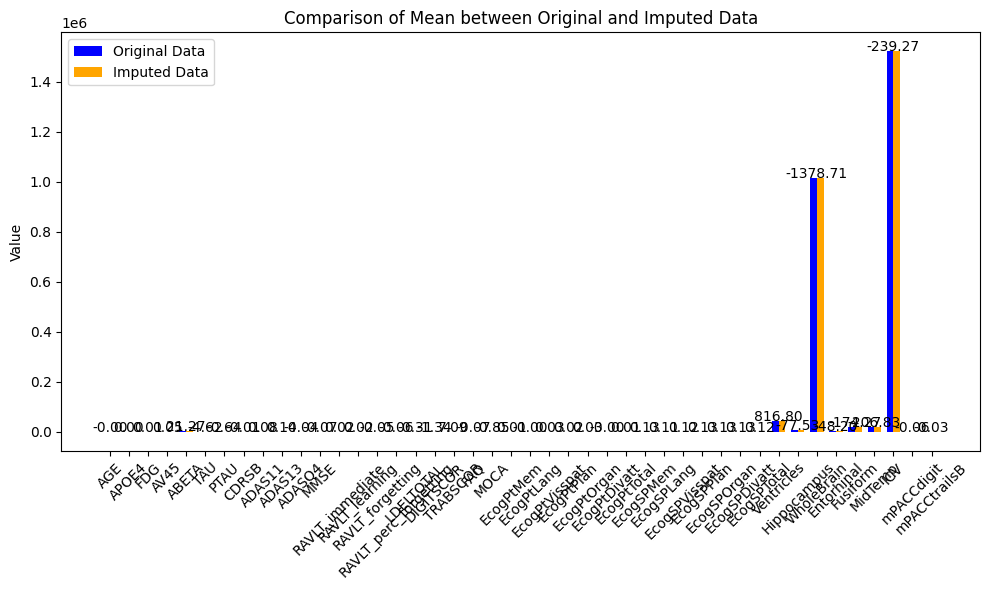

C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:218: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

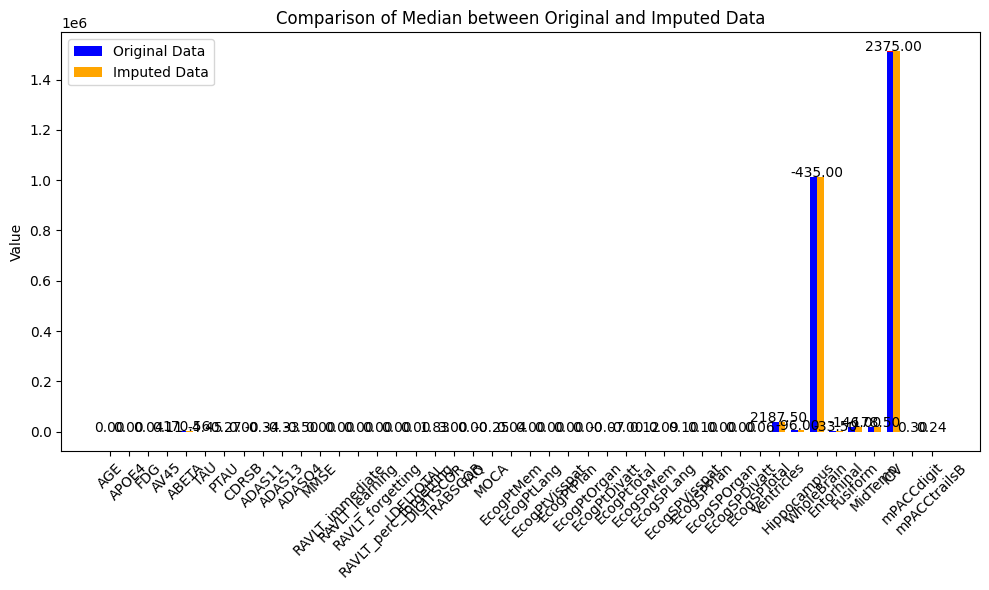

C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:218: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:219: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
C:\Users\uikra\AppData\Local\Temp\ipykernel_16268\4010764434.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

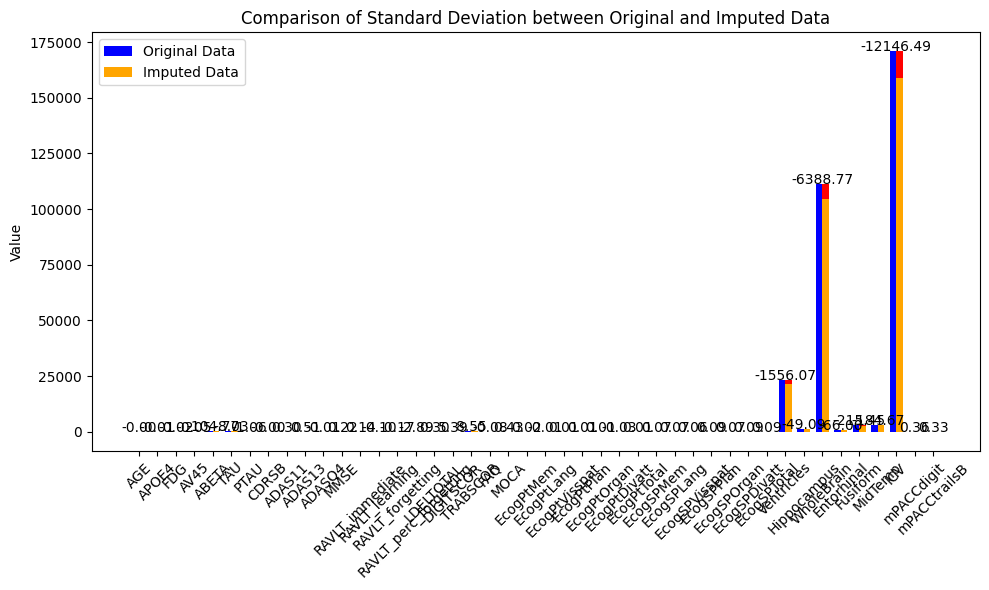

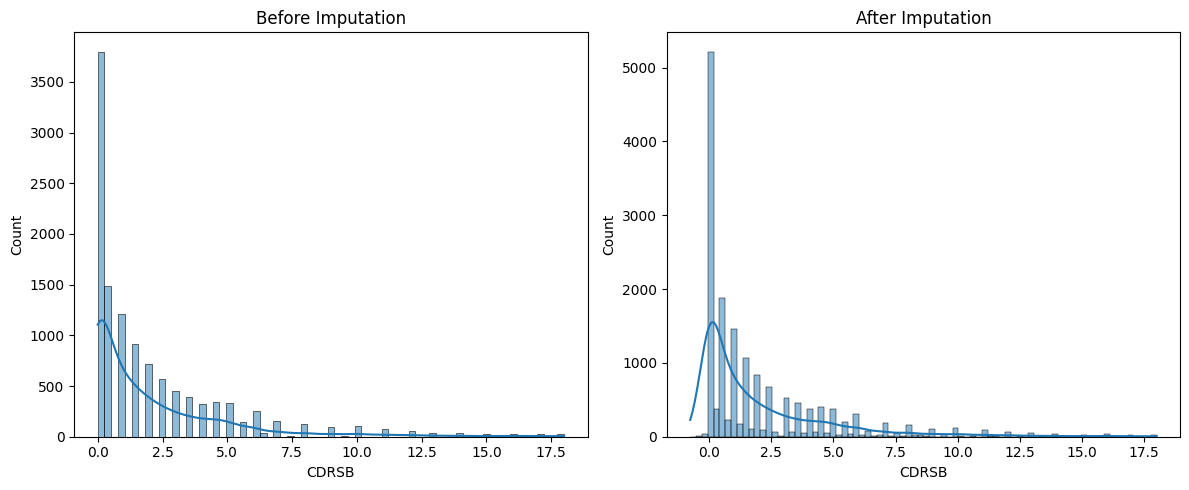

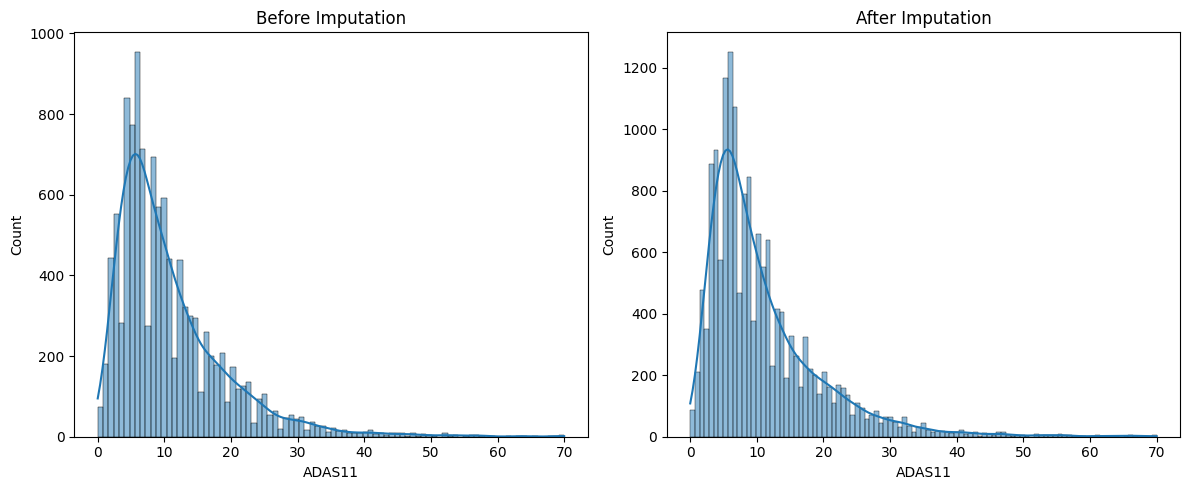

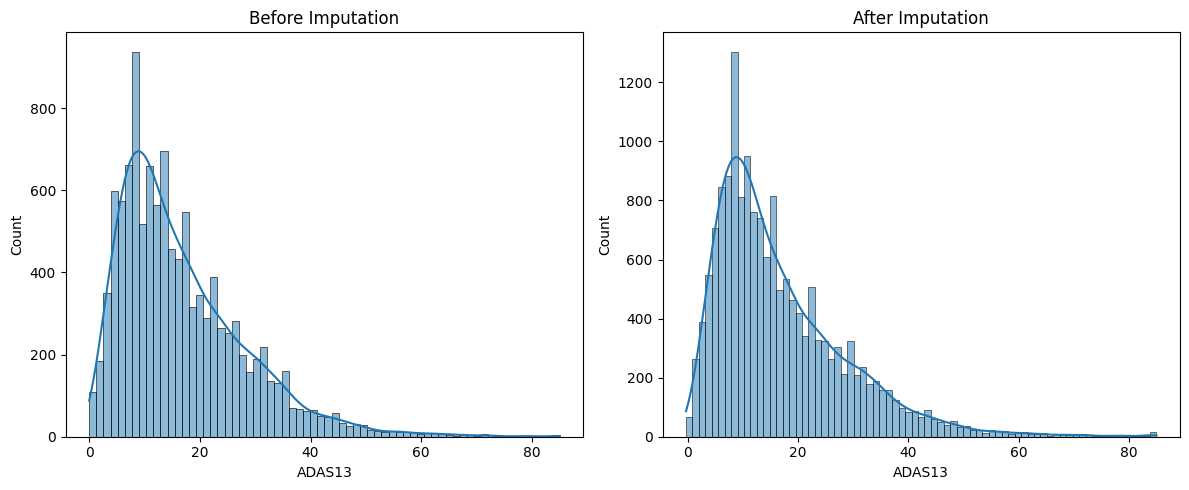

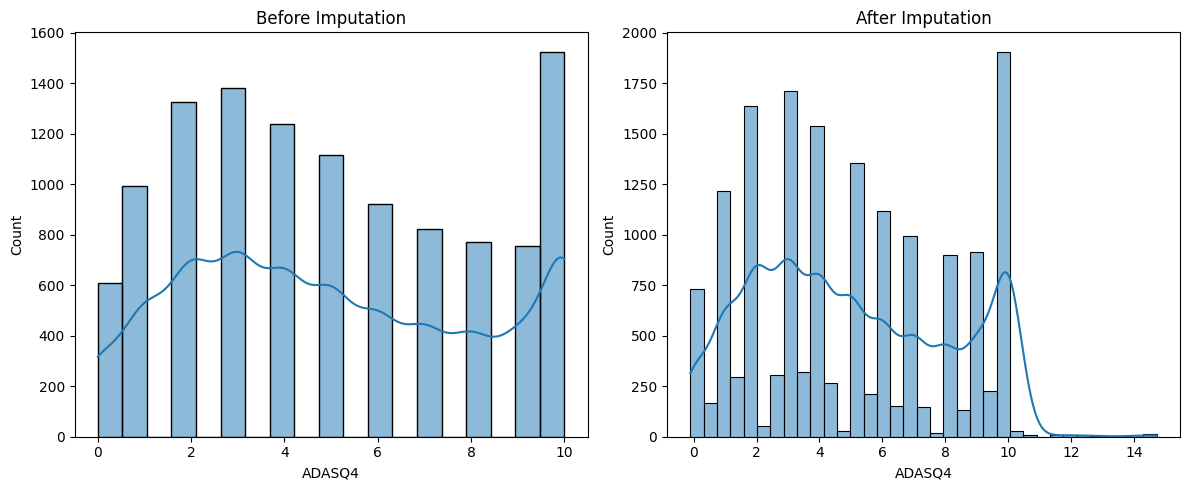

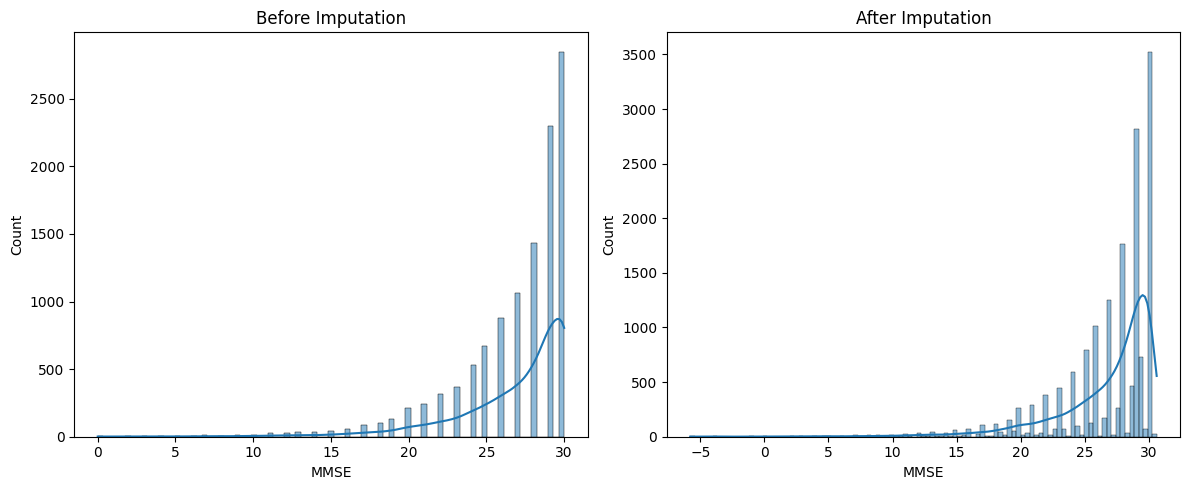

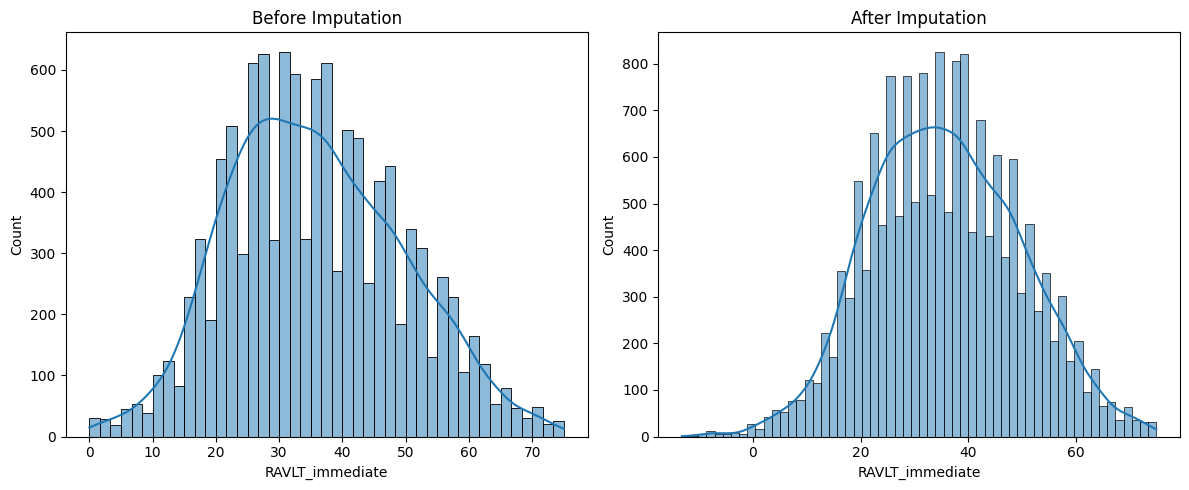

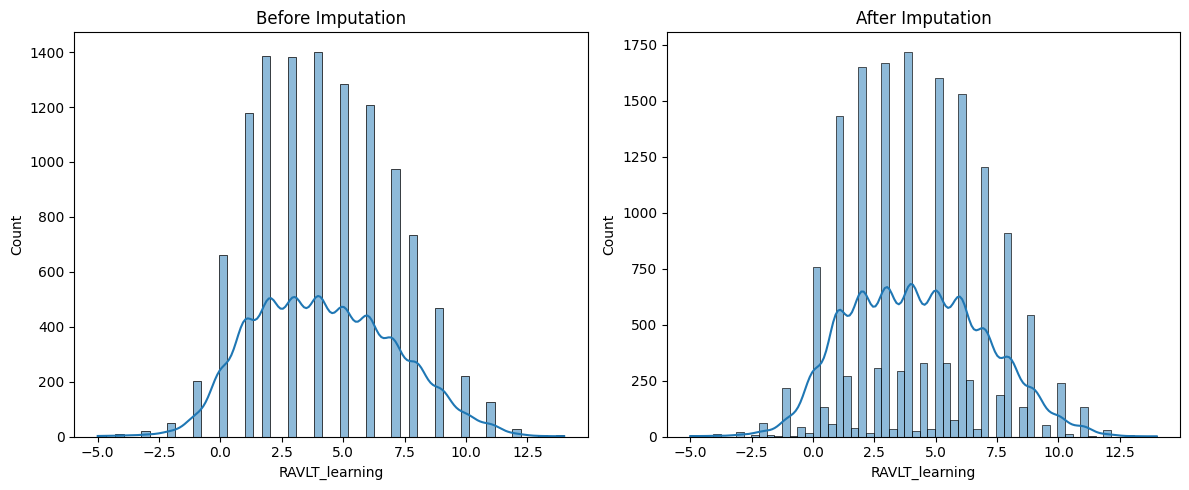

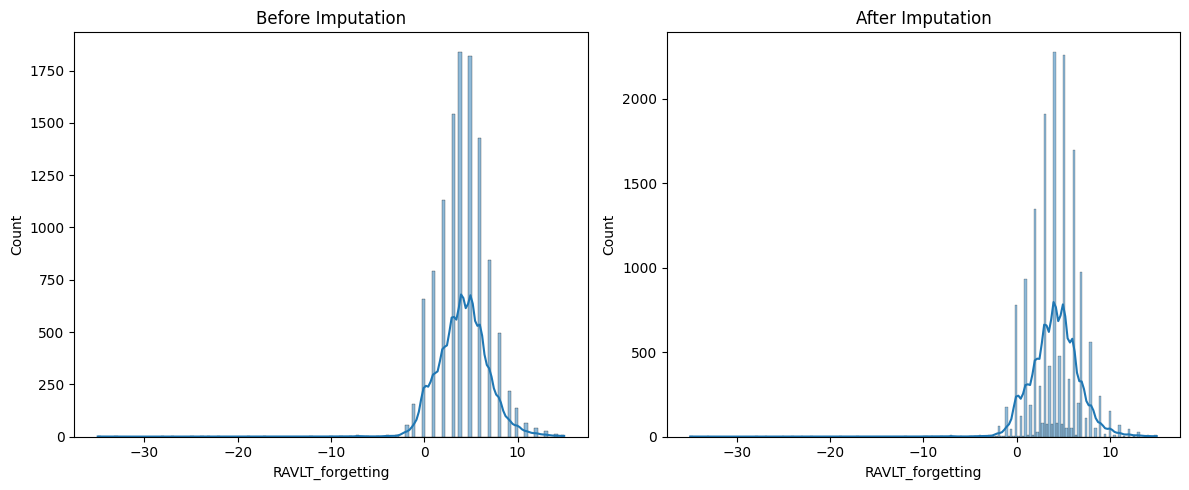

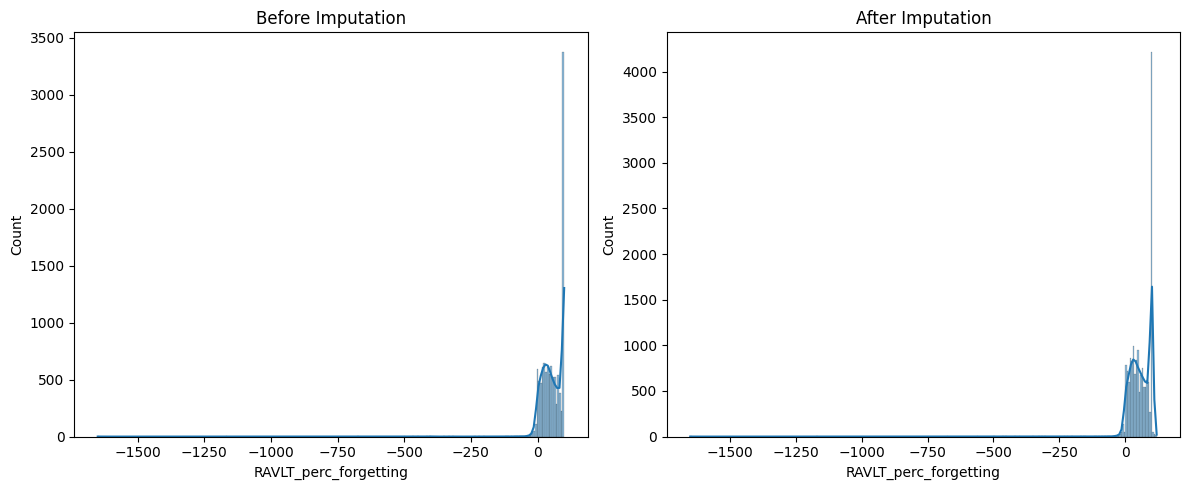

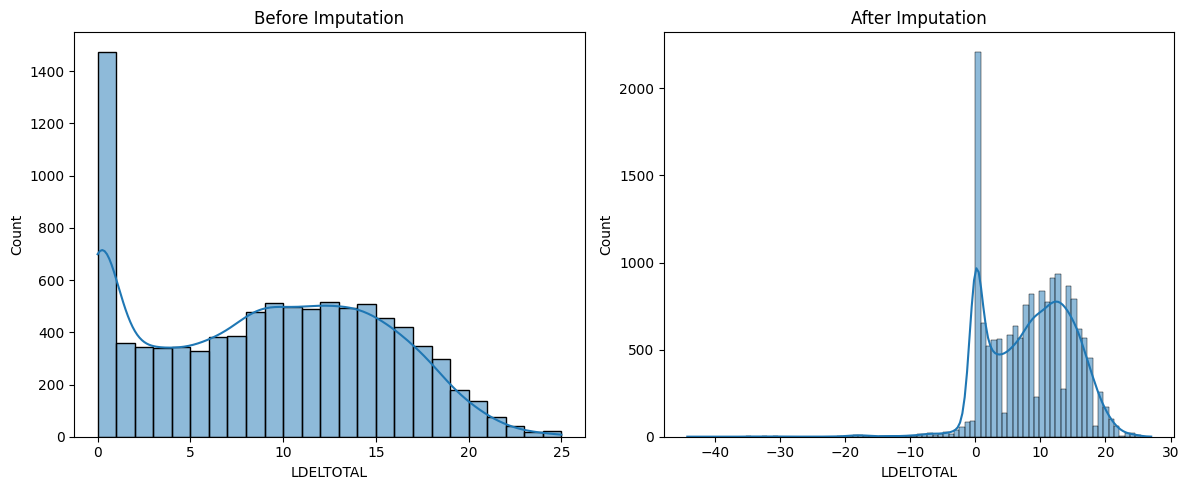

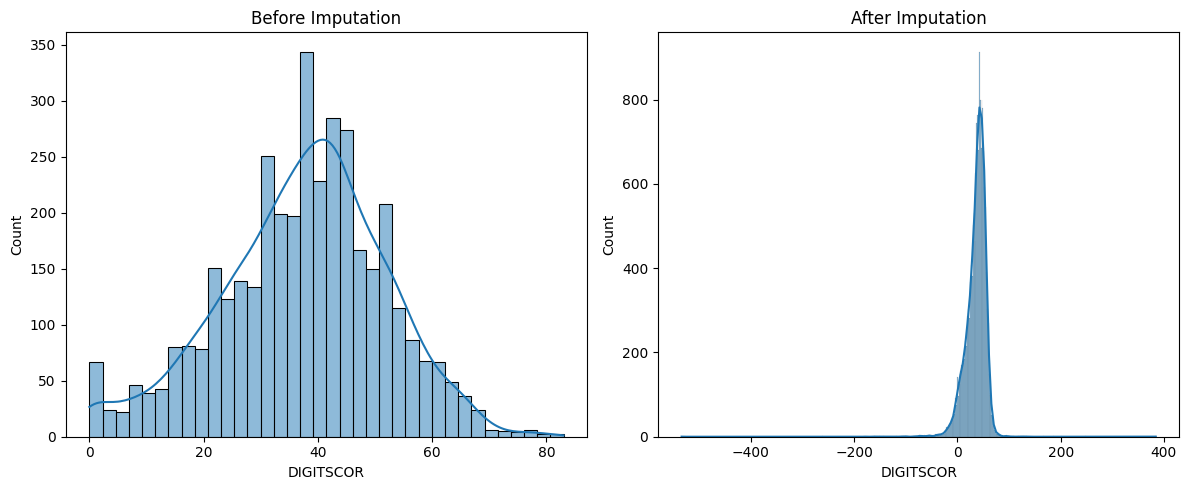

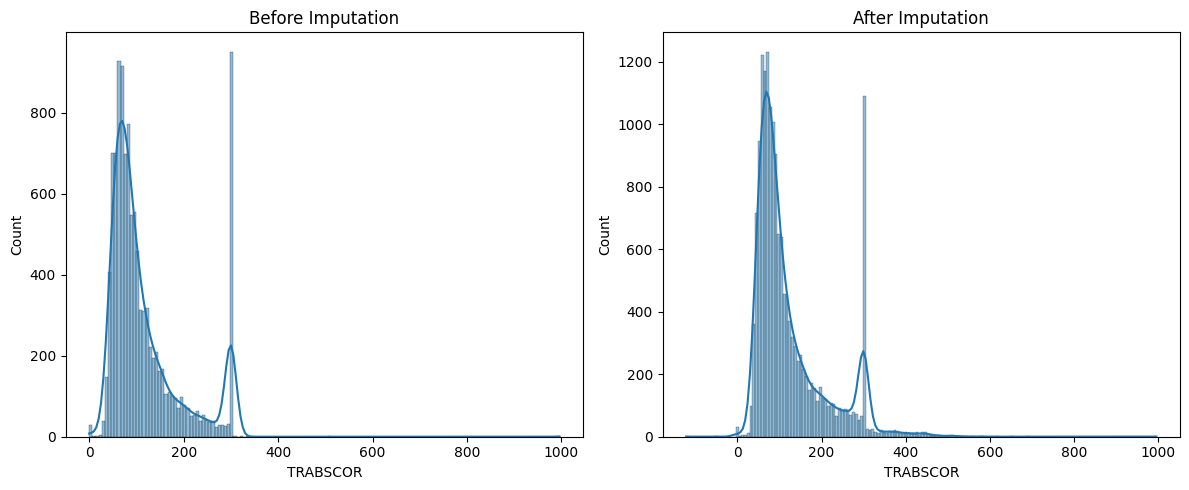

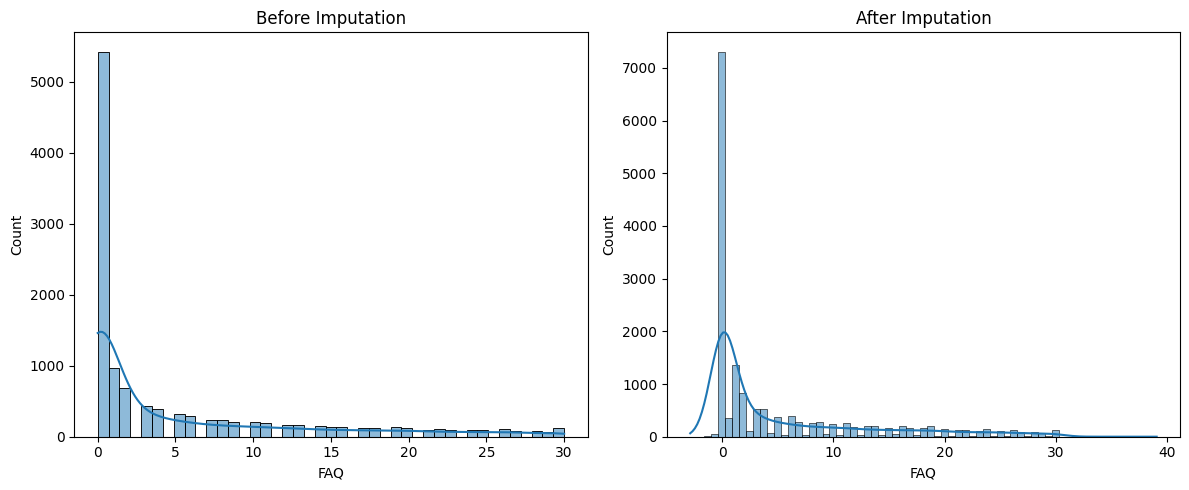

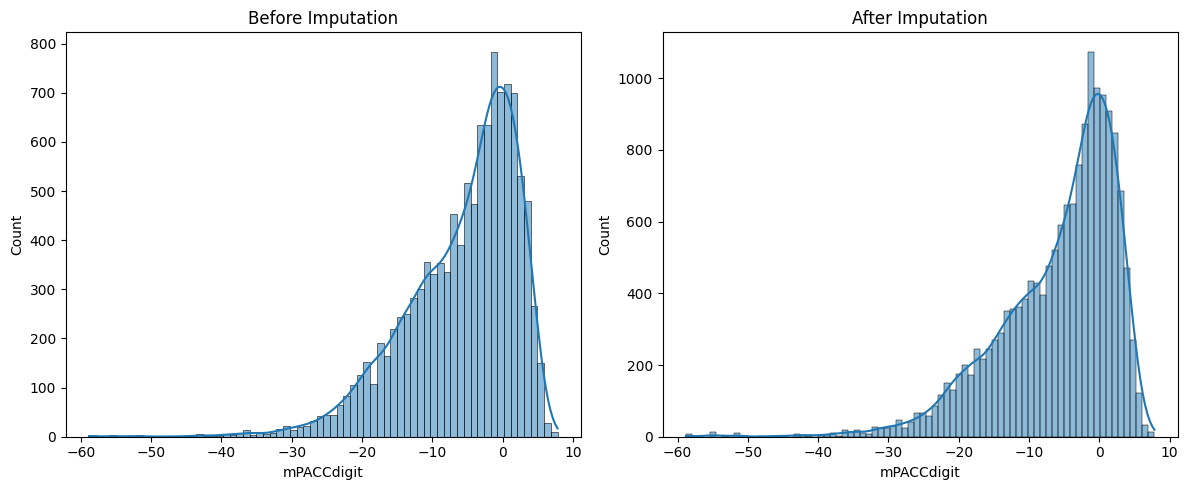

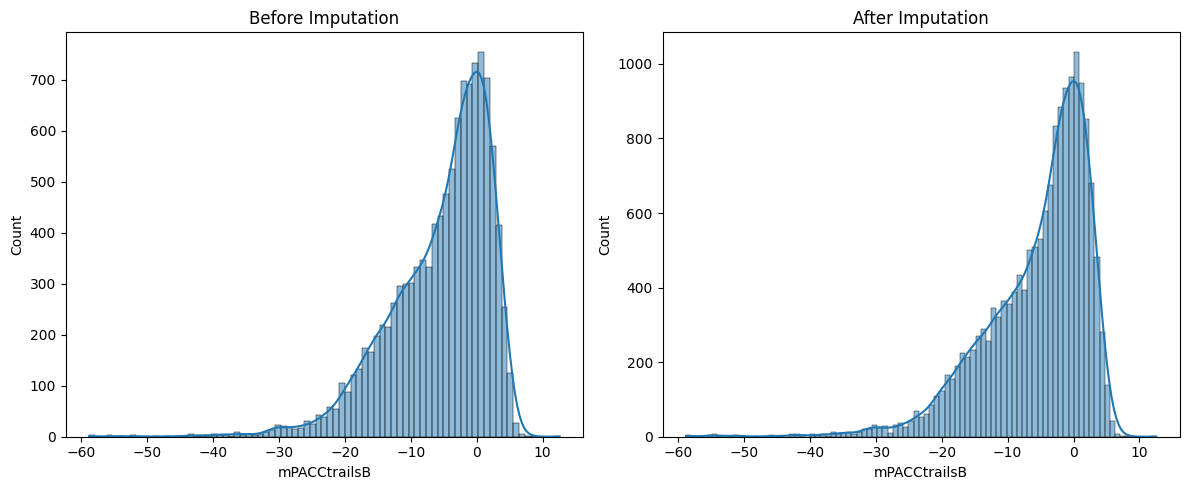

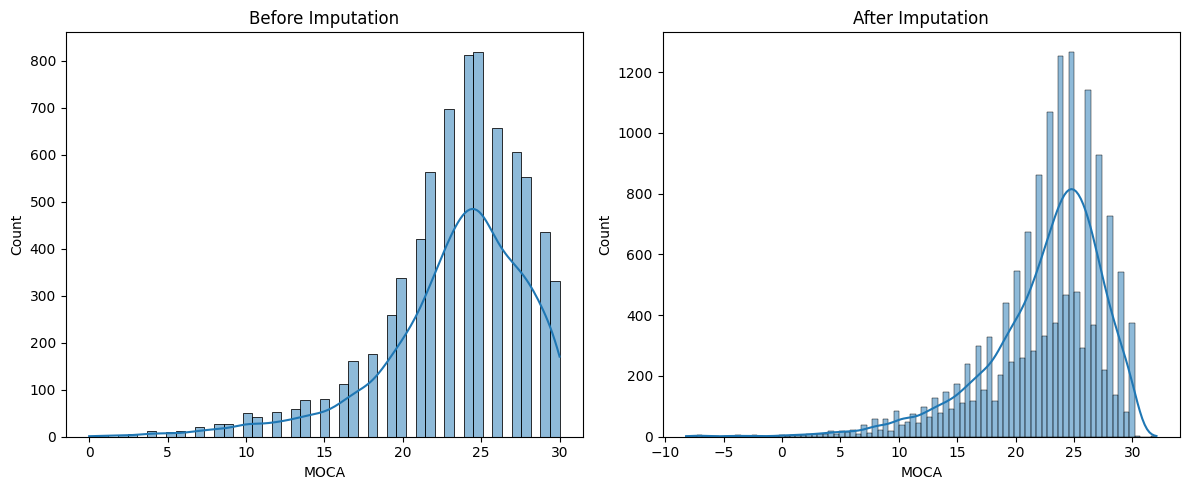

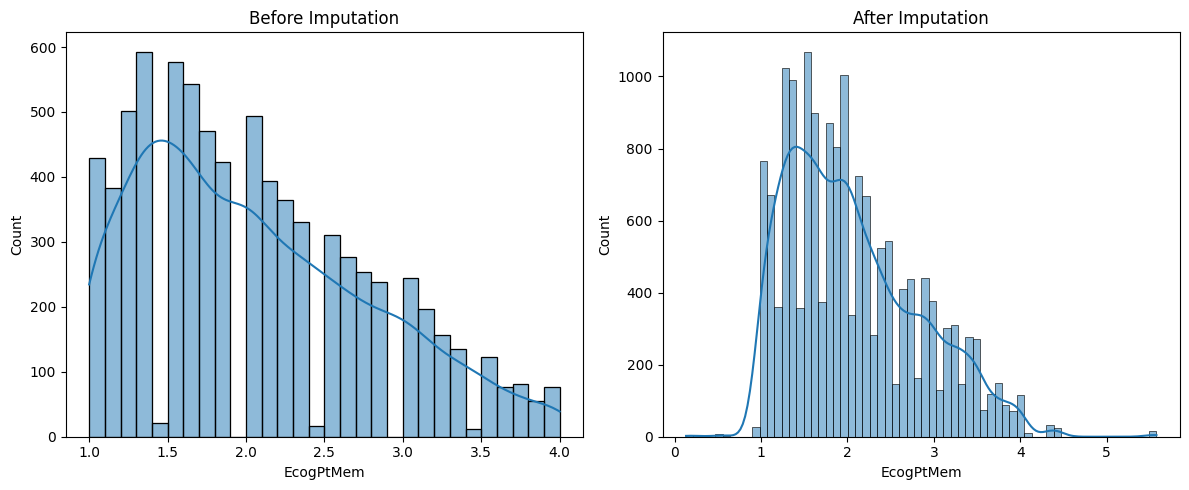

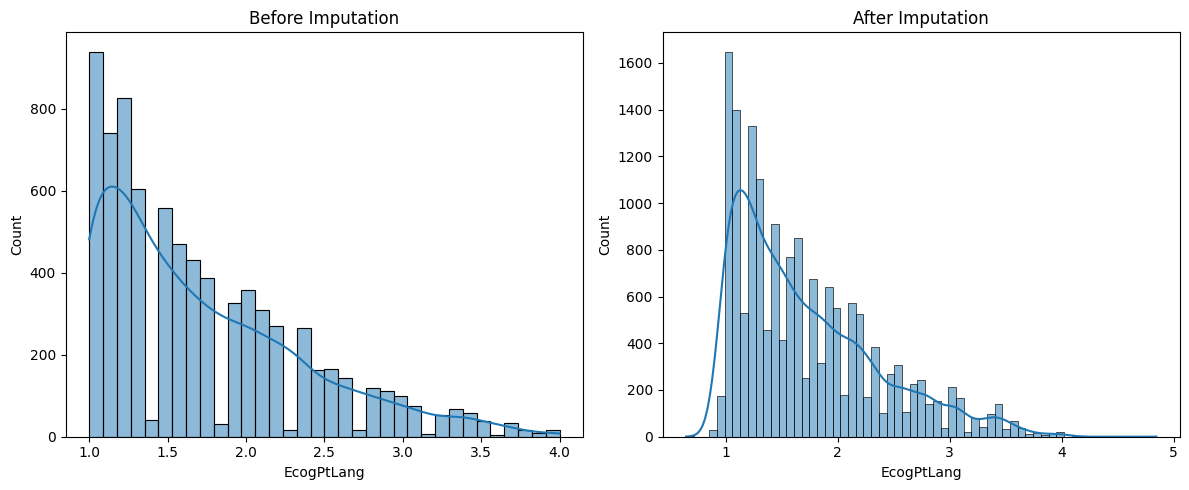

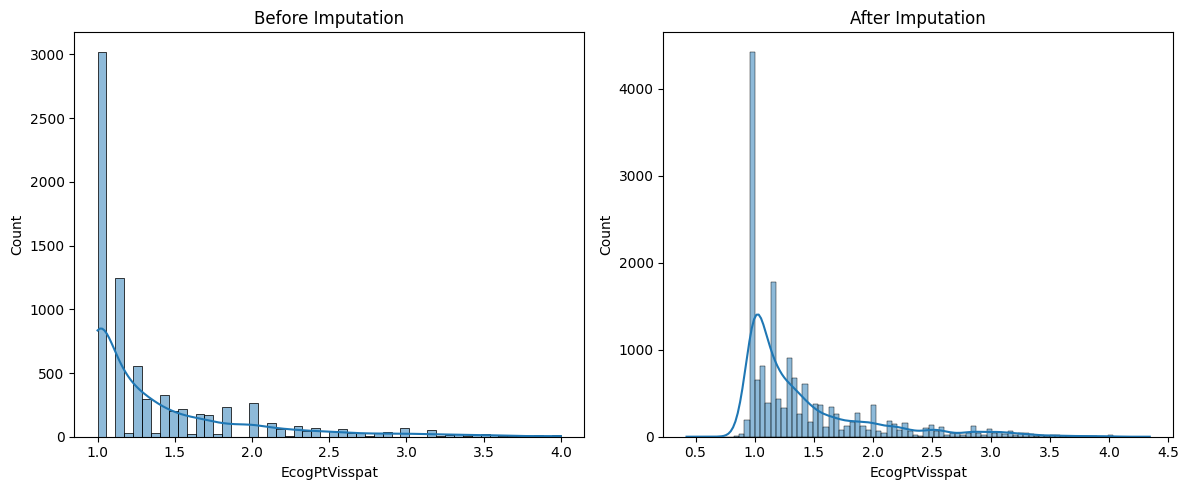

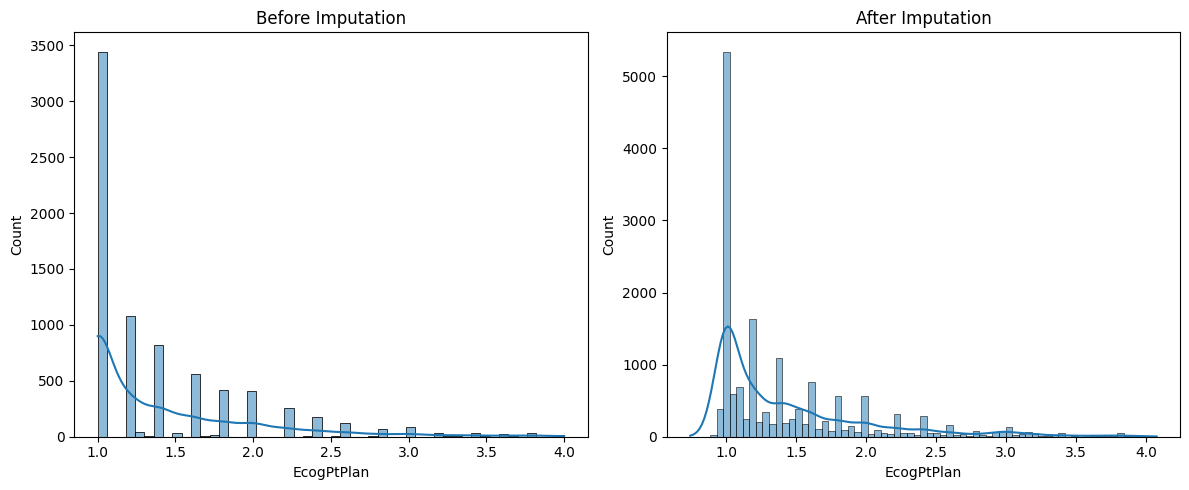

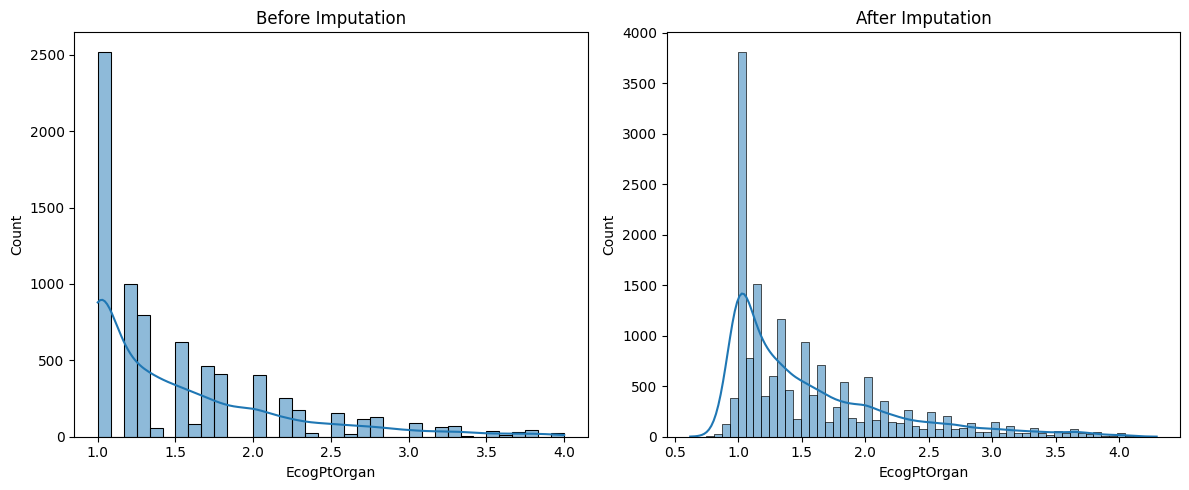

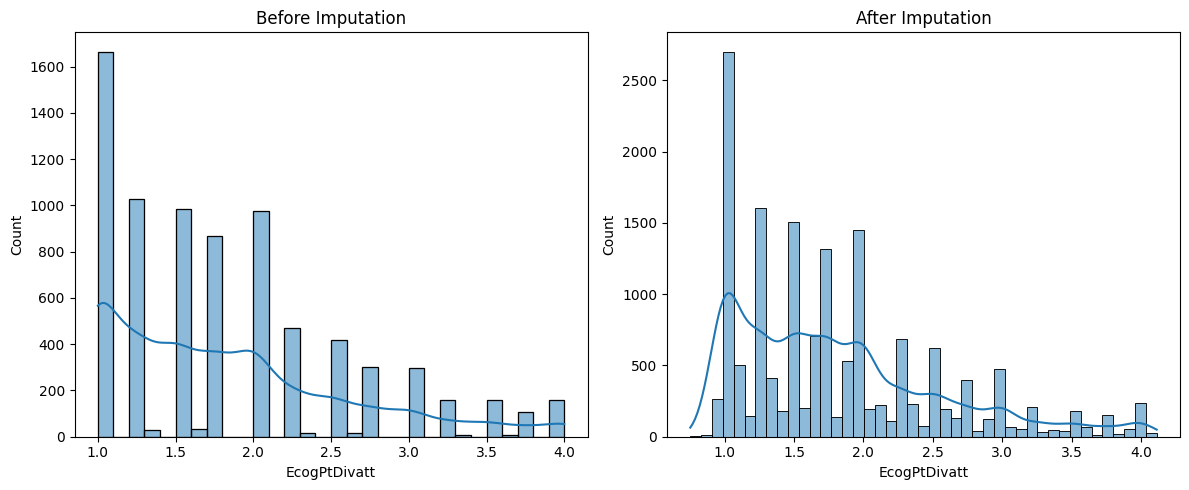

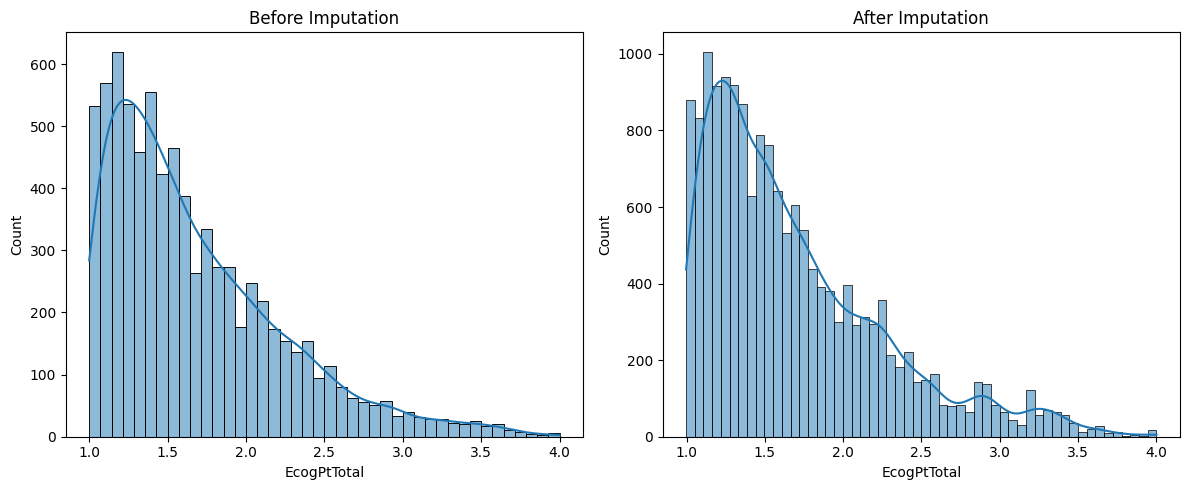

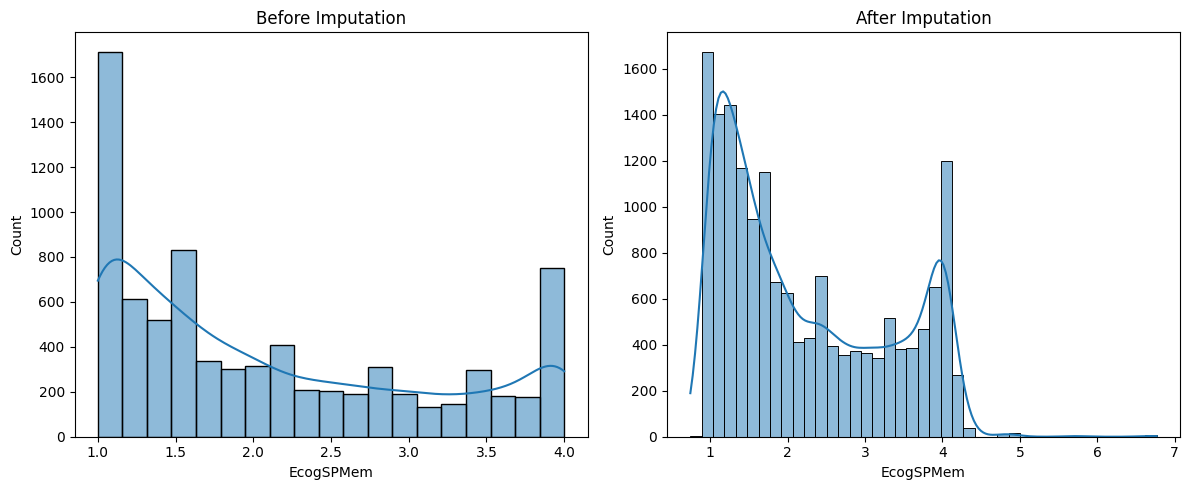

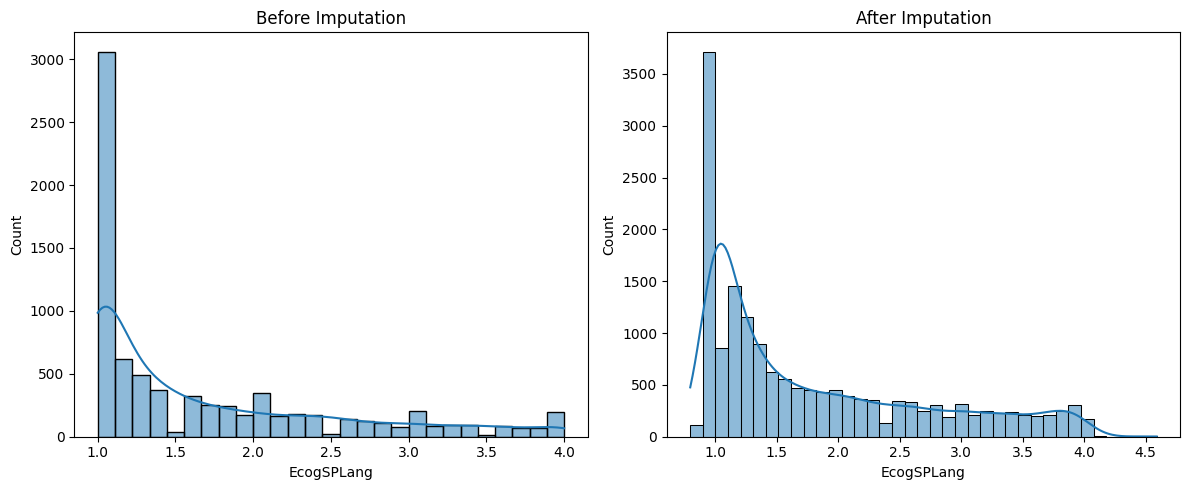

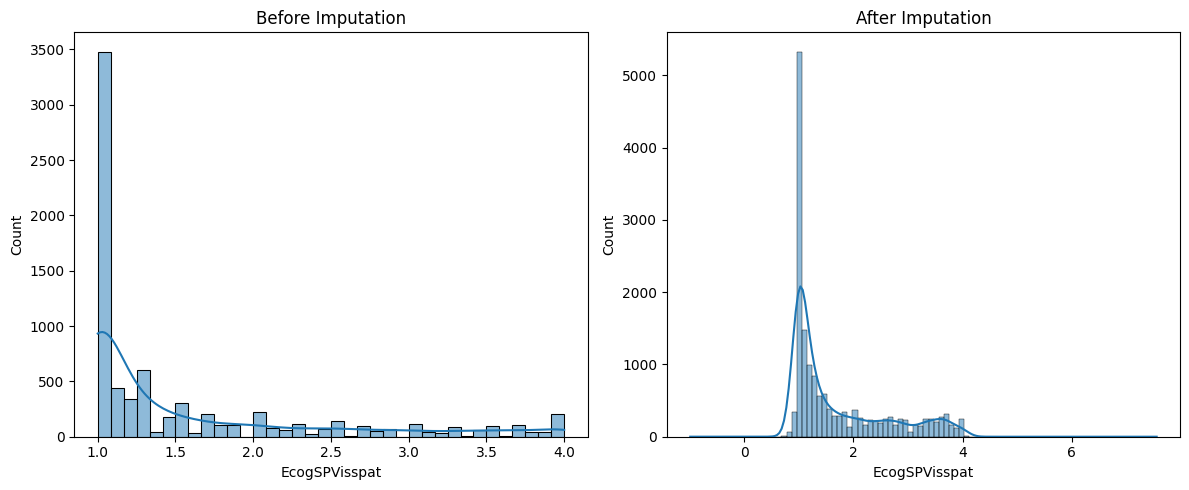

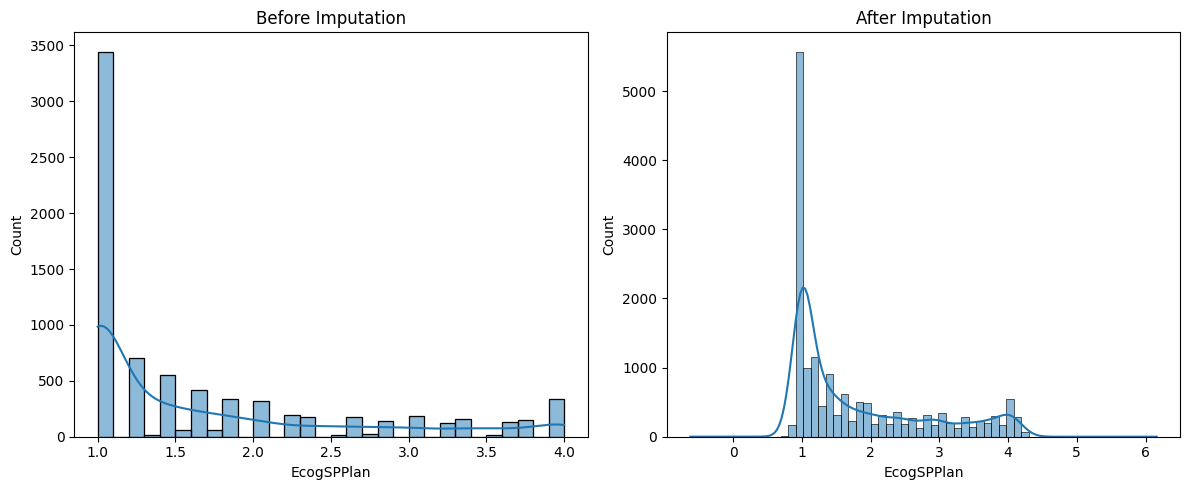

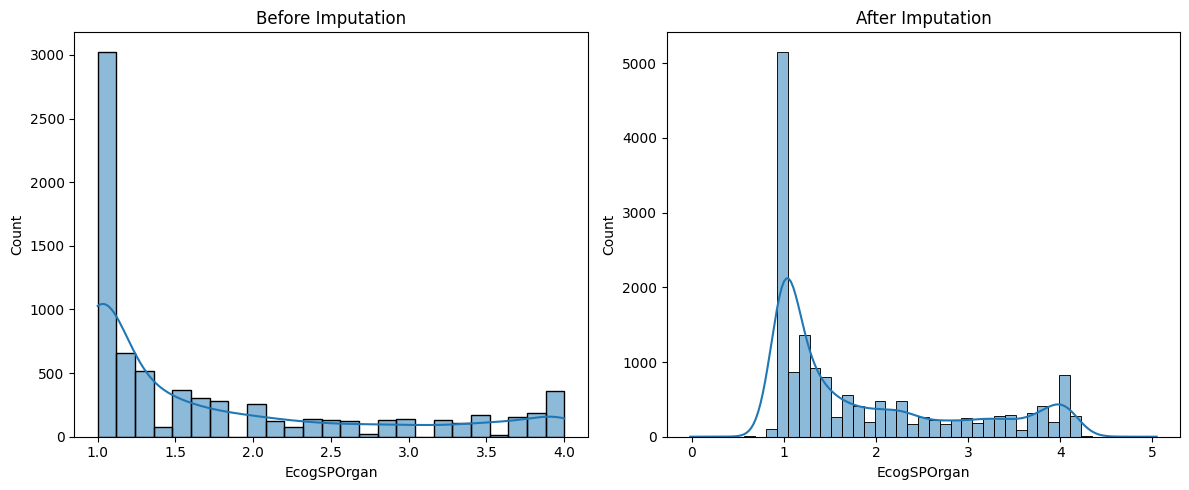

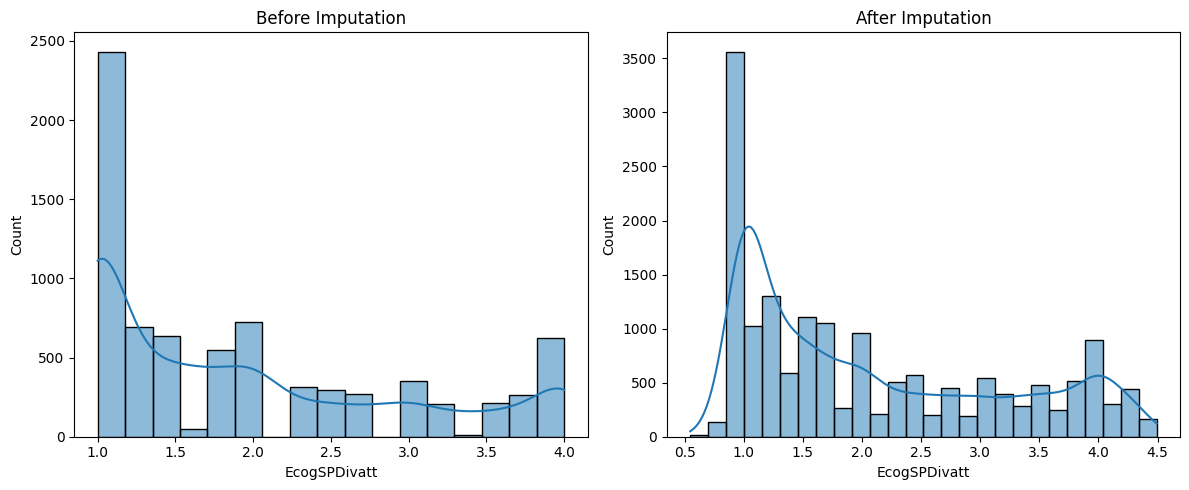

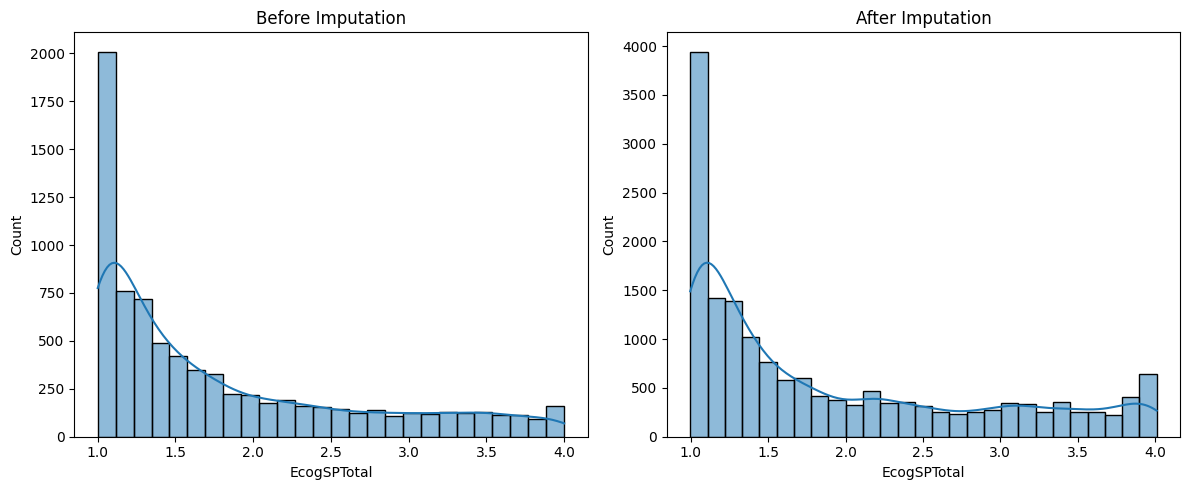

In [4]:
# For All ADNI Data
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Load the data
file_path = 'Alldata.csv'
clinical_data = pd.read_csv(file_path)


# Calculating distribution parameters to compare after Imputation
columns_to_average = ['AGE','APOE4','FDG','AV45','ABETA','TAU','PTAU','CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV', 'mPACCdigit', 'mPACCtrailsB']
actual_average_value = clinical_data[columns_to_average].mean()
actual_median_value = clinical_data[columns_to_average].median()
actual_std_value = clinical_data[columns_to_average].std()

# Dropping Column that do not need Interpolation
columns_dropped_1 = clinical_data.iloc[:, 0:12]  #first 12 Columns
columns_dropped_2 = clinical_data.iloc[:, -2:]   #last 2 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Function for performing Interpolation only on those missing values that have available data above and below it.
def interpolate_missing_values(df, columns):
    for column in columns:
        # Find indices of missing values with both previous and next values available
        indices_missing_with_neighbors = df.index[
            df[column].isnull() & \
            df[column].shift(-1).notnull() & \
            df[column].shift(1).notnull()
        ]

        # Iterate over missing values with both neighbors and perform linear interpolation
        for idx in indices_missing_with_neighbors:
            prev_idx = idx - 1
            next_idx = idx + 1
            prev_value = df.at[prev_idx, column]
            next_value = df.at[next_idx, column]
            interpolated_value = (prev_value + next_value) / 2
            df.at[idx, column] = interpolated_value


columns_to_interpolate = ['APOE4','FDG','AV45','ABETA','TAU','PTAU','CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV', 'mPACCdigit', 'mPACCtrailsB']
# Perform linear interpolation for each column
interpolate_missing_values(clinical_data, columns_to_interpolate)

# Append the removed column back to the DataFrame
clinical_data = pd.concat([columns_dropped_1, clinical_data, columns_dropped_2], axis=1)

# Removing rows that have more than 8 missing values for the columns mentioned below
#columns_to_check = ['AGE', 'PTMARRY','CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']
# Calculate the number of null values in each row for the specified columns
#null_counts = clinical_data[columns_to_check].isnull().sum(axis=1)

# Drop rows where the count of null values exceeds the threshold (8)
#threshold = 22
#clinical_data = clinical_data.loc[null_counts <= threshold]

# Filling missing DX in Data
#clinical_data.loc[:, 'DX'] = clinical_data['DX'].ffill()


#clinical_data = clinical_data.dropna(subset=['APOE4'])


# At this stage data is interpolated and extra rows with majority data missing are removed.
# Now data is ready for MICE along with K-fold for validation

# Dropping Column that do not need Imputation
columns_dropped_1 = clinical_data.iloc[:, 0:12]  #first 10 Columns
columns_dropped_2 = clinical_data.iloc[:, -2:]   #last 4 Columns
clinical_data = clinical_data.drop(columns=columns_dropped_1 + columns_dropped_2)

# Initializing Data for MICE using LOCF
clinical_data_ffill = clinical_data.ffill()

# Using NOCB for missing data that does not have a starting value to carry forward
clinical_data_LOCF = clinical_data_ffill.bfill()

# Total number of iteration for which we will run MICE
Total_Imputation_Iteration = 10
for _ in range(Total_Imputation_Iteration):

  # Iterate over each feature column
  for column in clinical_data_LOCF.columns:

      # Replace the column with original missing values
      clinical_data_LOCF[column] = clinical_data[column].values

      # Check if there are any missing values in the column
      if clinical_data_LOCF[column].isnull().any():

        # Separate complete data and rows with missing values of the current column
        observed_data = clinical_data_LOCF.dropna(subset=[column])
        missing_data = clinical_data_LOCF[clinical_data_LOCF[column].isnull()]

        # Separate features and target variable
        X = observed_data.drop(columns=[column])
        y = observed_data[column]

        # Initialize 10-fold cross-validation
        k = 10
        kf = KFold(n_splits=k, shuffle=True, random_state=42) #Kfold is a class of scikit and has multiple function eg kf.split
        best_model = None
        best_val_score = float('inf')

        # Perform 10-fold cross-validation
        for train_index, val_index in kf.split(X):
            # Split data into training and validation sets
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Fit a linear regression model
            model = LinearRegression()
            #model = RandomForestRegressor()

            #model = GradientBoostingRegressor()

            #model = DecisionTreeRegressor()
            #model = SVR()
            #model = KNeighborsRegressor()
            model.fit(X_train, y_train)

            # Model Validation
            y_pred = model.predict(X_val)

            # Calculate mean squared error on validation set
            val_score = mean_squared_error(y_val, y_pred)

            # Update best model if current model has lower validation score
            if val_score < best_val_score:
                best_val_score = val_score
                best_model = model

        average_value = observed_data[column].mean()
        print("Best validation score (mean squared error) and average for ", column, " is :", best_val_score, "  /  ", average_value)

        # Predict missing values
        predicted_values = best_model.predict(missing_data.drop(columns=[column]))

        # This statement is only MICE, replacing missing with predicted values
        # Update clinical_data_LOCF with predicted values
        clinical_data_LOCF.loc[missing_data.index, column] = predicted_values

        # This statement makes MICE along with PMM, it replaces missing values with data already available in that feature closest to predicted value)
        # Find closest observed values
        #closest_indices = pairwise_distances_argmin_min(predicted_values.reshape(-1, 1), observed_data[column].values.reshape(-1, 1))[0]
        #closest_values = observed_data.iloc[closest_indices][column]

        # Replace missing values with closest observed values
        #clinical_data_LOCF.loc[missing_data.index, column] = closest_values


# Done processing all columns
print()
print("All missing values are imputed using MICE for",Total_Imputation_Iteration,"Iterations and updated in clinical_data_LOCF.")

# Append the removed column back to the DataFrame
clinical_data_imputed = pd.concat([columns_dropped_1, clinical_data_LOCF, columns_dropped_2], axis=1)

# Removing patient rows which have no diagnosis, age or marriage status.
#columns_to_check = ['AGE', 'PTMARRY', 'Calculated Diagnosis']

# Check for null values in the specified columns
#missing_values_mask = clinical_data_imputed[columns_to_check].isnull().any(axis=1)

# Filtering the DataFrame to remove rows based on the combined mask
#clinical_data_imputed = clinical_data_imputed[~missing_values_mask]

# Filling missing DX in Data
#clinical_data_imputed.loc[:, 'DX'] = clinical_data_imputed['DX'].ffill()
clinical_data_imputed1 = clinical_data_imputed.ffill()

clinical_data_imputed1.to_csv('Imputed_data_Alldata.csv',index=False)
# clinical_data_imputed1.to_csv('/content/drive/My Drive/Imputed_data_Alldata.csv',index=False)
# files.download('Imputed_data_Alldata.csv')


# Calculating distribution parameters to compare after Original
columns_to_average = ['AGE','APOE4','FDG','AV45','ABETA','TAU','PTAU','CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal','Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp','ICV', 'mPACCdigit', 'mPACCtrailsB']
imputed_average_value = clinical_data_imputed[columns_to_average].mean()
imputed_median_value = clinical_data_imputed[columns_to_average].median()
imputed_std_value = clinical_data_imputed[columns_to_average].std()

# List of statistics to compare
statistics = ['Mean', 'Median', 'Standard Deviation']

# List of corresponding data values
data_values = [actual_average_value, actual_median_value, actual_std_value]
imputed_values = [imputed_average_value, imputed_median_value, imputed_std_value]

# Define the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(data_values[0]))

# Loop through each statistic and generate the plot
for stat, original_val, imputed_val in zip(statistics, data_values, imputed_values):
    # Calculate the difference between original and imputed values
    difference = imputed_val - original_val
    min_val = np.minimum(imputed_val, original_val)

    # Create a bar chart with bars on top of each other
    plt.figure(figsize=(10, 6))

    # Plot original data bars
    plt.bar(x, original_val, color='blue', width=bar_width, label='Original Data')

    # Plot imputed data bars
    plt.bar(x + bar_width, imputed_val, color='orange', width=bar_width, label='Imputed Data')

    # Plot difference bars
    for i, diff in enumerate(difference):
        if diff > 0:
            plt.bar(x[i], diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, imputed_val[i] + 2, f'{diff:.2f}', ha='center', color='black')
        else:
            plt.bar(x[i] + bar_width, -diff, color='red', width=bar_width, alpha=1, bottom=min_val[i])
            plt.text(x[i] + bar_width / 2, original_val[i] + 2, f'{diff:.2f}', ha='center', color='black')

    # Set limits, labels, and title
    plt.xticks(x + bar_width / 2, original_val.index, rotation=45)  # Assuming index contains labels
    plt.ylabel('Value')
    plt.title(f'Comparison of {stat} between Original and Imputed Data')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histogram for comparing Distribution of original v/s imputed data
# Load the data
file_path = 'Alldata.csv'
original_data1 = pd.read_csv(file_path)

# Function for histogram creation
def compare_distributions(original_df, imputed_df, variables):
    for variable in variables:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot original distribution
        sns.histplot(original_df[variable].dropna(), kde=True, ax=axes[0])
        axes[0].set_title('Before Imputation')

        # Plot distribution after imputation
        sns.histplot(imputed_df[variable], kde=True, ax=axes[1])
        axes[1].set_title('After Imputation')

        plt.tight_layout()
        plt.show()

columns_of_interest = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'mPACCdigit', 'mPACCtrailsB','MOCA','EcogPtMem','EcogPtLang','EcogPtVisspat','EcogPtPlan','EcogPtOrgan','EcogPtDivatt','EcogPtTotal','EcogSPMem','EcogSPLang','EcogSPVisspat','EcogSPPlan','EcogSPOrgan','EcogSPDivatt','EcogSPTotal']

compare_distributions(original_data1, clinical_data_imputed, columns_of_interest)


In [ ]:
reference_code = """
# Same code as last iterative block but it also calculates test scores

# Total number of iteration for which we will run MICE
Total_Imputation_Iteration = 10
for _ in range(Total_Imputation_Iteration):

  # Iterate over each feature column
  for column in clinical_data_LOCF.columns:

      # Replace the column with original missing values
      clinical_data_LOCF[column] = clinical_data[column].values

      # Check if there are any missing values in the column
      if clinical_data_LOCF[column].isnull().any():

        # Separate complete data and rows with missing values of the current column
        observed_data = clinical_data_LOCF.dropna(subset=[column])
        missing_data = clinical_data_LOCF[clinical_data_LOCF[column].isnull()]

        # Separate features and target variable
        X = observed_data.drop(columns=[column])
        y = observed_data[column]

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Initialize 10-fold cross-validation
        k = 10
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        best_model = None
        best_val_score = float('inf')
        best_test_score = float('inf')

        # Perform 10-fold cross-validation
        for train_index, val_index in kf.split(X_train):
            # Split data into training and validation sets
            X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

            # Fit a linear regression model
            model = LinearRegression()
            model.fit(X_train_fold, y_train_fold)

            # Model Validation
            y_pred_val = model.predict(X_val)

            # Calculate mean squared error on validation set
            val_score = mean_squared_error(y_val, y_pred_val)

            # Update best model if current model has lower validation score
            if val_score < best_val_score:
                best_val_score = val_score
                best_model = model

        # Model Test
        y_pred_test = best_model.predict(X_test)
        # Calculate mean squared error on validation set
        test_score = mean_squared_error(y_test, y_pred_test)

        print("Best Validation score (mean squared error) and best test score for ", column, " is :", best_val_score,"/",test_score)

        # Predict missing values
        predicted_values = best_model.predict(missing_data.drop(columns=[column]))

        # This statement is only MICE, replacing missing with predicted values
        # Update clinical_data_LOCF with predicted values
        # clinical_data_LOCF.loc[missing_data.index, column] = predicted_values

        # This statement makes MICE along with PMM, it replaces missing values with data already available in that feature closest to predicted value
        # Find closest observed values
        closest_indices = pairwise_distances_argmin_min(predicted_values.reshape(-1, 1), observed_data[column].values.reshape(-1, 1))[0]
        closest_values = observed_data.iloc[closest_indices][column]

        # Replace missing values with closest observed values
        clinical_data_LOCF.loc[missing_data.index, column] = closest_values

# Done processing all columns
print()
print("All missing values are imputed using MICE for",Total_Imputation_Iteration,"Iterations and updated in clinical_data_LOCF.")
"""
